# PREPARACION DE DATOS

En esta fase se crearán nuevas variables o se transformarán las existentes para poder dar mejor respuesta a los objetivos de negocio.

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

## CARGA DE DATOS

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df', con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bathrooms_text,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,2,180,Excellent connection with the AIRPORT and EXHI...,t,2,1 shared bath,1.0,1.0,80,4.87,4.89,4.77,5098
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,2,364,We have a quiet and sunny room with a good vie...,f,1,1 bath,1.0,1.0,33,4.58,4.82,4.21,2267
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,5,222,"Apartamento de tres dormitorios dobles, gran s...",f,6,2 baths,3.0,5.0,0,NaN,NaN,NaN,4085
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,1,115,"Studio located 50 meters from Gran Via, next t...",f,3,1 bath,1.0,1.0,12,4.92,5.00,5.00,4827
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,1,349,Nice and cozy roon for one person with a priva...,f,1,1 private bath,1.0,1.0,149,4.68,4.71,4.70,4085


## PREPARACION DE VARIABLES

### Creacion de KPIs de palancas

Primero se crearán las variables de análisis, es decir las que habíamos sido previamente identificadas como los KPIs que se emplearán en las palancas que influyen sobre el negocio.

Eran 3:

* precio por noche: ya recogida directamente en la variable price.
* ocupación: se dispone de la variable availability_365 pero hay que transformarla.
* precio del inmueble: deberá ser creada con variables.

**Precio:**

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Se intentará entender analizando el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Por lo que primero se elegirá un distrito que tenga muchos datos.

In [3]:
df.distrito.value_counts()

AttributeError: 'DataFrame' object has no attribute 'distrito'

In [ ]:
df.loc[df.distrito == 'Centro',:].groupby('room_type').price.mean()

Conclusión:
    
* alquilar el apartamento tiene un precio medio de 148€.
* alquilar una habitación tiene un precio medio de 60€ o 67€ según sea compartida o privada.
* por tanto para calcular los "ingresos" de un inmueble se deberá multiplicar el precio el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room.

Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto se debería ponderar por el porcentaje medio de habitaciones alquiladas.

No se dispone de ese dato. Se supondrá que tras hablar con el responsable de negocio y se ha obtenido, siendo del 70%.

In [ ]:
def crear_precio_total(registro):
    if (registro.beds > 1) & ((registro.room_type == 'Private room') | (registro.room_type == 'Shared room')):
        salida = registro.price * registro.beds * 0.7
    else:
        salida = registro.price
    return(salida)

df['precio_total'] = df.apply(crear_precio_total, axis = 1)

Comprobación.

In [ ]:
df[['room_type','price','beds','precio_total']].head(30)

**Ocupación:**

La variable que permite medir esto es availability_365. Indica el número de días a un año vista que el inmueble NO está ocupado.

Por tanto interesaría transformarla a una medida más directa de ocupación, por ejemplo el % del año que SI está ocupada.

In [ ]:
df['ocupacion'] = ((365 - df.availability_365) / 365 * 100).astype('int')
df.head()

### Transformación de varaibles de análisis

Algunas de las preguntas semilla están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Normalmente estos análisis se pueden ejecutar mejor si se discretiza la variable de análisis.

Las candidatas para este análisis son: accommodates, bedrooms, beds y number_of_reviews.

En bedrooms tiene sentido una discretización más personalizada. En las otras puede hacerse de forma automática.

**Discretizar bedrooms**

Evaluación de la distribución de los datos.

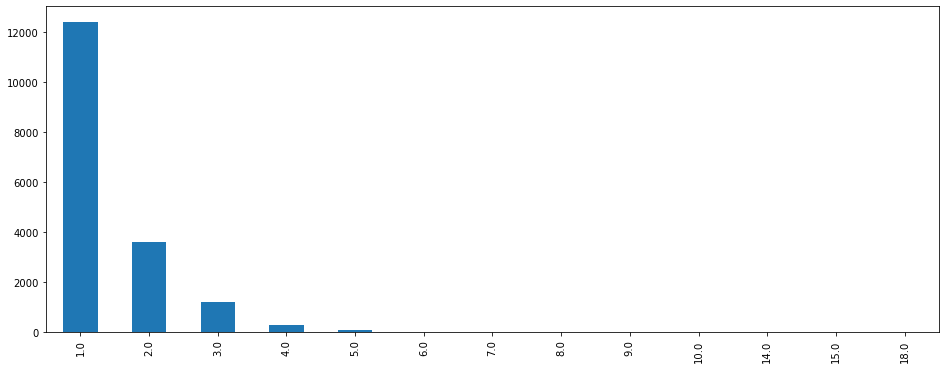

In [4]:
df.bedrooms.value_counts().plot.bar(figsize=(16,6));

Se discretizará para 1,2,3 y más de 3 bedrooms.

In [5]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]

resultados = ['01_Una','02_Dos','03_Tres','04_Cuatro o mas']

df['bedrooms_disc'] = np.select(condiciones, resultados, default = -999)

Comprobación.

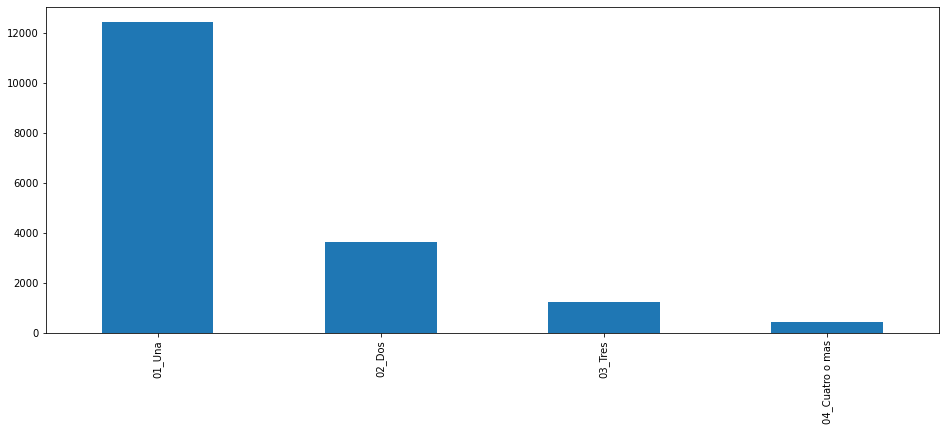

In [6]:
df.bedrooms_disc.value_counts().plot.bar(figsize=(16,6));

**Discretizar accommodates, beds y number_of_reviews**

Se empleará qcut para discritizar con percentiles 0.5, 0.8, 1

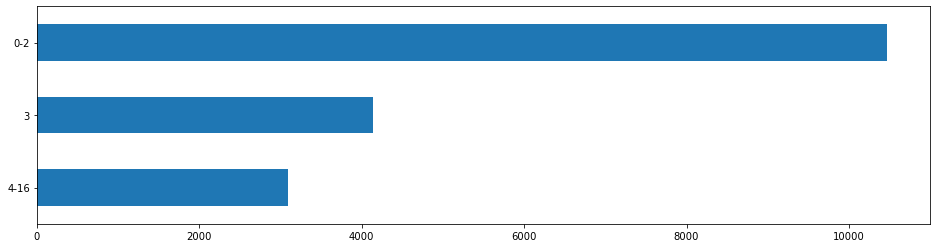

In [7]:
df['accommodates_disc'] = pd.qcut(df.accommodates,[0, 0.5, 0.8, 1],
                                 labels = ['0-2','3','4-16'])

df['accommodates_disc'].value_counts().sort_index(ascending = False).plot.barh(figsize=(16,4));

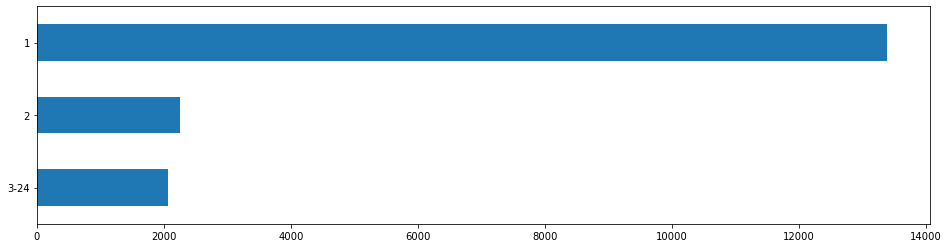

In [8]:
df['beds_disc'] = pd.qcut(df.beds,[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh(figsize=(16,4));

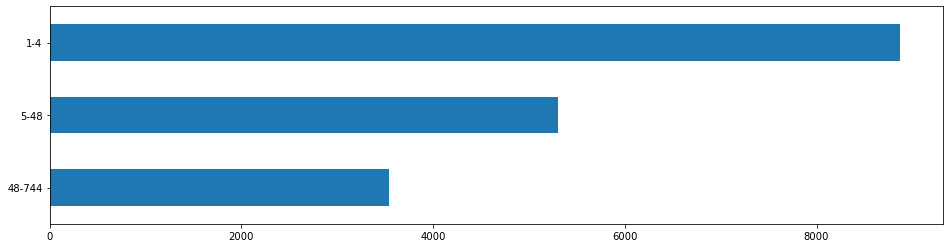

In [9]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh(figsize=(16,4));

### Creación de variables con datos externos

Ya se ha incorporado parcialmente la palanca del precio del inmueble.

Como se indicaba anteriormente, se estimará multiplicando los metros cuadrados del inmueble por el precio por m2.

Ya se dispone del precio_m2, pero el tamaño del inmueble no se tiene en los datos actualmente.

Se estimará a partir de unos criterios en base al número de habitaciones. No es perfecto, pero servirá como aproximación.

**Estimación de los metros cuadrados del inmueble**

Criterios considerados:
* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120
* cinco o más habitaciones: m2 = 150

In [152]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]

resultados = [50,70,90,120,150]

df['m2'] = np.select(condiciones, resultados, default = -999)

Comprobación.

In [153]:
df['m2'].value_counts()

50     12422
70      3617
90      1228
120      296
150      147
Name: m2, dtype: int64

Ya puede estimarse el precio de compra del inmueble.

Recordamos que se minorizaba el precio un 30% por capacidad de negociación.

In [154]:
df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

Comprobación.

In [155]:
df[['bedrooms','m2','distrito','precio_m2','precio_compra']].head(20)

,bedrooms,m2,distrito,precio_m2,precio_compra
0,1.0,50,Chamartín,5098,178430.0
1,1.0,50,Latina,2267,79345.0
2,3.0,90,Arganzuela,4085,257355.0
3,1.0,50,Centro,4827,168945.0
4,1.0,50,Arganzuela,4085,142975.0
5,3.0,90,Arganzuela,4085,257355.0
6,1.0,50,Centro,4827,168945.0
7,1.0,50,Centro,4827,168945.0
8,2.0,70,Centro,4827,236523.0
9,1.0,50,Centro,4827,168945.0


Podrían calcularse las distancias a diferentes puntos de interés como monumentos, lugares de ocio, recintos deportivos, etc.

Simplemente como ejemplo se calculará la distancia de cada inmueble a la Puerta del Sol.
- Latitud: 40.4167278
- Longitud: -3.7033387

**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con la fórmula conocida como distancia de Haversine.

In [157]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

Se crea la variable:

In [158]:
#Las coordenadas de la Puerta del Sol serán lat1 y lon1
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

Se comprueba y revisa la distancia media por distritos:

In [159]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.730611
Arganzuela                1.939114
Chamberí                  2.133167
Retiro                    2.450593
Salamanca                 2.715975
Moncloa - Aravaca         3.294526
Usera                     3.928874
Latina                    3.942634
Carabanchel               3.970238
Chamartín                 4.432842
Puente de Vallecas        4.481127
Tetuán                    4.624605
Moratalaz                 5.073901
Ciudad Lineal             5.231293
Villaverde                7.664192
Fuencarral - El Pardo     8.062301
Hortaleza                 8.074184
San Blas - Canillejas     8.199011
Vicálvaro                 8.599559
Villa de Vallecas         9.176618
Barajas                  11.439064
Name: pdi_sol, dtype: float64

## GUARDADO EN EL DATAMART

In [173]:
df.to_sql('df_preparado', con = con, if_exists = 'replace')